<center><font size="+2"> <br>
Hidden Information in Restaurant Reviews<br>
Analyis Using Topic Modelling and Sententiment Analysis<br>
<font size="+1">CS410 Final Project Fall 2021<br>
John Hanratty (johnh7), Reynold Chan></center>

# Objectives
This final project focused on developing an application to use data mining techniques to analyze textual customer restaurant reviews to understand and quantify preferences and satisfaction. The application utilizes latent topics extracted from the data to categorize customer interests.  Customer sentiment is also extracted from the reviews to augument time, location, ratings and user infomation in the data set.  Use cases for this application include♒

- Informing restaurant owners on how they stack up,
- Indentifying topics that drive customer satisfaction,
- Giving customers a better selection criteria for choosing a place to eat.

To accomplish this, our application ingests large amounts of textual customer restaurant reviews to extract latent topics and customer sentiment. The data set was selected and curated to provide rich customer sourced text with date, user, location and other useful contextual information (e.g. ratings). The project allowed us to evaluate and choose from a number of topic and sentiment modeling techniques. The contextual data from the data set is enriched with extracted topic and sentiment informatio to enamble analysis of customer's experiences. The final data set is used to create reports that expose actionable insight that help restaurants improve customer experience and customers choose restaurants via finer grained preferences.



# Contents
- Introduction
- Data Set Selection, Processing and Contents
- Topic Modelling
- Sentiment Modelling
- Customer Reports

In [ ]:
#@title Load Libraries and Data Files {display-mode: "form"}
#@markdown **RUN THIS CELL** to load configuration, libraries and data files use by *all scripts in this document.* 
%%capture 
# %%capture hides output / remove if you need to debug

import sys
import os.path
import time
from datetime import datetime
import pytz
import json
import numpy as np
import pandas as pd
import pickle
from pprint import pprint
from random import randint
import warnings
from google.colab import output
import textwrap
if 'prettytable' not in sys.modules:
  !pip3 install prettytable
from prettytable import PrettyTable
 

if 'geopandas' not in sys.modules:
  !pip install geopandas
import geopandas as gpd
if 'pyproj' not in sys.modules:
  !pip install pyproj
from pyproj import Proj, CRS, transform

from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.colors as mcolors

# Juniper Widgets
# https://ipywidgets.readthedocs.io/en/latest/changelog.html?highlight=interact_manual 
from __future__ import print_function
from ipywidgets import Layout, interact, interactive, interactive_output, fixed, IntSlider, RadioButtons, IntProgress
import ipywidgets as widgets

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import train_test_split

if 'colorama' not in sys.modules:
  print('...installing colorama')
  !pip install colorama
from colorama import Fore, Back, Style


# Download file to directory and set HOMEDIR below
# Get files here: https://drive.google.com/drive/folders/1t7WcptSE-kH04-zqK13E8FkXGcu8QSKg?usp=sharing 
HOMEDIR = '/content/drive/MyDrive/Colab_Notebooks/ProjectDat/'

DSREV_SAVE = HOMEDIR + 'ds_yelp_rev_dsMA'
DSBIZ_SAVE = HOMEDIR + 'ds_yelp_biz_dsMA'
DSID = 'YELP1M'  # IMDB, YELP
DSTRAIN = HOMEDIR + 'cs410' + DSID + '_ds_train'
DSTEST = HOMEDIR + 'cs410' + DSID + '_ds_test'
# for Gensim Models
LDAMODEL = HOMEDIR + 'cs410' + DSID + '_ldamodel'
BOwTEST = HOMEDIR + 'cs410' + DSID + '_bow_test'
BOwTRAIN = HOMEDIR + 'cs410' + DSID + '_bow_train'
LDADICT = HOMEDIR + 'cs410' + DSID + '_dict'
# for Scikit Models
SCIMODEL_LDA = HOMEDIR + 'cs410' + DSID + '_scimodel_lda'
SCIMODEL_NMF = HOMEDIR + 'cs410' + DSID + '_scimodel_nmf'
SCIMODEL_TFLDA = HOMEDIR + 'cs410' + DSID + '_scimodel_tflda'
SCIMODEL_TFNMF = HOMEDIR + 'cs410' + DSID + '_scimodel_tfnmf'
SCIMODEL_TFLDA_VECT = HOMEDIR + 'cs410' + DSID + '_scimodel_tflda_vect'
SCIMODEL_TFNMF_VECT = HOMEDIR + 'cs410' + DSID + '_scimodel_tfnmfvect'
SCIMODEL_NMF_FEATURES = HOMEDIR + 'cs410' + DSID + '_scimodel_ldafeatures'
SCIMODEL_LDA_FEATURES = HOMEDIR + 'cs410' + DSID + '_scimodel_nmffeatures'
SCIMODEL_TFNMF_TFIDF =  HOMEDIR + 'cs410' + DSID + '_scimodel_tfnmf_tfidf'
SCIMODEL_TFLDA_TF = HOMEDIR + 'cs410' + DSID + '_scimodel_tflda_tf'

#READ YELP REVIEW and BUSINESS DATA SETS
with open(DSREV_SAVE, 'rb') as f:
  yelp_ds1 = pickle.load(f)
yelp_ds1.reset_index(drop=True, inplace=True)

with open(DSBIZ_SAVE, 'rb') as f:
  business_df = pickle.load(f)
business_df.reset_index(drop=True, inplace=True)

# READ TEST AND DATA SETS
with open(DSTRAIN, 'rb') as f:
    ds_train = pickle.load(f)

with open(DSTEST, 'rb') as f:
    ds_test = pickle.load(f)
ds_test.reset_index(drop=True, inplace=True)

# READ PRE-TRAINED SCIKIT MODELS
with open(SCIMODEL_LDA, 'rb') as f:
    lda = pickle.load(f)

with open(SCIMODEL_TFLDA, 'rb') as f:
    tf_fit = pickle.load(f)

with open(SCIMODEL_TFLDA_VECT, 'rb') as f:
    tf_vectorizer = pickle.load(f)

with open(SCIMODEL_TFLDA_TF, 'rb') as f:
    tf = pickle.load(f)

with open(SCIMODEL_LDA_FEATURES, 'rb') as f:
    tf_feature_names = pickle.load(f)


with open(SCIMODEL_NMF, 'rb') as f:
    nmf = pickle.load(f)

with open(SCIMODEL_TFNMF, 'rb') as f:
    tfidf_fit = pickle.load(f)

with open(SCIMODEL_TFNMF_VECT, 'rb') as f:
    tfidf_vectorizer = pickle.load(f)

with open(SCIMODEL_TFNMF_TFIDF, 'rb') as f:
    tfidf = pickle.load(f)

with open(SCIMODEL_NMF_FEATURES, 'rb') as f:
    tfidf_feature_names = pickle.load(f)


# READ GENSIM PRETRAINED MODEL AND BOW FROM DSTEST DATASET
with open(LDAMODEL, 'rb') as f:
    lda_model = pickle.load(f)

with open(BOwTEST, 'rb') as f:
    bow_test = pickle.load(f)

with open(BOwTRAIN, 'rb') as f:
    bow_train = pickle.load(f)  #bow_corpus

with open(LDADICT, 'rb') as f:
    lda_dict = pickle.load(f)


print('DS_TRAIN SHAPE:', ds_train.shape)
print('DS_TEST SHAPE:', ds_test.shape)


# Routine for findng out how many topics are used in a model
def topic_count(mod):
  try:  
    p = mod.get_params()['n_components']
    return p
  except:
    pass
  try:
    p = mod.get_topics().shape[0]
    return p
  except:
    p = 10
  return p








# Dataset Based on Yelp Reviews
The final application utilizes a customized restaurant review data set from [Yelp Open Dataset](https://www.yelp.com/dataset).  The original raw dataset contains$:$
- 8.6M reviews (7GB)
- 160K businesses (124MB)
- 2.2M users (3.4GB)
- 200K pictures
- 8 metropolitan areas

The raw dataset is available from Yelp in JSON format with separate files for reviews, businesses, users, tips, check-ins and photos.  

The raw Yelp dataset was processed to create a smaller, focused data source for our application. Specifically, the business data (e.g. restaurant) and review data were joined and filtered to include only restaurants in Massachusetts. Data fields were filtered down, combined and transformed to provide more succinct contextual data (e.g. reviews dates, location, ratings).  The final data set contains 1.36 million reviews which was divided into test and training sets.  The structure is shown below.

In [ ]:
#@title Yelp Dataset Extraction Scripts {display-mode: "form"}
#@markdown **WARNING THIS REQUIRES YOU TO DOWNLOAD THE YELP JSON FILES.** \
#@markdown This section is provided for completeness but is not required 
#@markdown to run the remaining cells in this notebook since the extracted data set files are provided.  The data set is 10GB 
#@markdown and takes an more than an hour to complete.  The dataset is available at [Yelp Open Dataset](https://www.yelp.com/dataset) 
#@markdown Put the JSON files in the directory defined by the HOMEDIR variable.
import json
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split

# YOU NEED TO CHANGE THIS TO THE DIRECTORY FOR THE YELP JSON FILES 
# download: https://www.yelp.com/dataset 
xHOMEDIR = ''  #HOMEDIR  # use HOMEDIR or other directory for pocesssing
#######

REVIEW = xHOMEDIR + 'yelp_academic_dataset_review.json'
TIP = xHOMEDIR + 'yelp_academic_dataset_tip.json'
CHECKIN = xHOMEDIR + 'yelp_academic_dataset_checkin.json'
USER = xHOMEDIR + 'yelp_academic_dataset_user.json'
BUSINESS = xHOMEDIR + 'yelp_academic_dataset_business.json'


####################
# LOAD REVIEw DATA
review_data = []
try:
  with open(REVIEW) as f:
    for line in f:
        review_data.append(json.loads(line))
except:
  print('Yelp JSON files are not in the HOMEDIR directory. You can download these files from https://www.yelp.com/dataset.')
  print('NOTE: You do not need to run this cell to run the rest of the cells in this notebook')
  raise
review_df = pd.DataFrame.from_dict(review_data)
print('Before NaN Drop', len(review_df))
review_df = review_df.dropna(how='any')
print('After NaN Drop', len(review_df))

review_df = review_df.rename(columns = {'text': 'review'})
review_df = review_df[['business_id', 'user_id', 'date', 'stars', 'review']]
print(review_df)

#####################
# LOAD BUSINESS DATA
business_data = []
with open(BUSINESS) as f:
    for line in f:
        business_data.append(json.loads(line))
business_df = pd.DataFrame.from_dict(business_data)
business_df = business_df.rename(columns = {'name': 'BusinessName', 'stars': 'rating'})

business_df = business_df[['business_id', 'BusinessName','city', 'state', 'longitude', 'latitude', 'rating', 'review_count', 'categories' ]]

print(business_df.head())

#####################
# Join reviews with busines
yelp_ds1 = review_df.set_index('business_id').join(business_df.set_index('business_id'), on='business_id', how='left')

yelp_ds1.reset_index(drop=True, inplace=True)
print('Length:', len(yelp_ds1))
yelp_ds1.head()

#####################
## FINAL PROCESSING OF DATA SET

# Remove NaNs
print('Before Length', len(yelp_ds1))
yelp_ds1 = yelp_ds1.dropna(how='any')
print('After NaN Drop', len(yelp_ds1))

## Get restaurants only
yelp_ds1 = yelp_ds1[yelp_ds1['categories'].str.contains("Restaurant")]
print('Restaurants', len(yelp_ds1))

##  Get Massachusetts only
# massacusetts
lat_min = 41.0
lat_max = 43.0
lon_min = -74.0
lon_max = -69.5

rev_in = len(yelp_ds1)
yelp_ds1 =  yelp_ds1[(yelp_ds1['latitude'] >= lat_min) & 
(yelp_ds1['latitude'] < lat_max) &
(yelp_ds1['longitude'] >= lon_min) & 
(yelp_ds1['longitude'] <= lon_max)]
print('In Range Reviews', len(yelp_ds1), 'Out of Range Reviews', rev_in - len(yelp_ds1))

# old MA
#print('States before', yelp_ds1.groupby('state').count())
#yelp_ds1 = yelp_ds1[yelp_ds1['state'] == 'MA']
#print('Massachusetts')
#yelp_ds1.groupby('state').count()

## Fix date format 
yelp_ds1['date'] = pd.to_datetime(yelp_ds1['date'])

##################
# SAVE DATASETs
import pickle
xDF_SAVE = xHOMEDIR + 'yelp_dsMA.csv'
xDSREV_SAVE = xHOMEDIR + 'ds_yelp_rev_dsMA'
xDSBIZ_SAVE = xHOMEDIR + 'ds_yelp_biz_dsMA'
xDSTRAIN = xHOMEDIR + 'cs410' + DSID + '_ds_train'
xDSTEST = xHOMEDIR + 'cs410' + DSID + '_ds_test'

# SAVE DATA SET TO CSV
yelp_ds1.to_csv(xDF_SAVE)

# SAVE DATA SET & Busines Data Set via pickle (if you want))
import pickle

#yelp_ds1.reset_index(drop=True, inplace=True) 
#with open(xDSREV_SAVE, 'wb') as f:
#  pickle.dump(yelp_ds1, f)

#business_df.reset_index(drop=True, inplace=True) 
#with open(xBIZ_SAVE, 'wb') as f:
#  pickle.dump(business_df, f)

ds = pd.read_csv(xDF_SAVE)
ds_train, ds_test = train_test_split(ds, test_size=0.2, random_state=25)
ds_train.reset_index(drop=True, inplace=True)
ds_test.reset_index(drop=True, inplace=True)

# Save Models to Disk 
with open(xDSTRAIN, 'wb') as f:
    pickle.dump(ds_train, f)

with open(xDSTEST_NMF, 'wb') as f:
    pickle.dump(ds_test, f)





In [ ]:
#@title Project Dataset Structure {display-mode: "form"}
#@markdown  The structure of the input data set used for this project is shown below. \
#@markdown The extraction creates ds_train and ds_test for model training and testing. \
from sklearn.model_selection import train_test_split
print(yelp_ds1.info())

CREAT_TEST_TRAIN_SETS = False
if CREAT_TEST_TRAIN_SETS: 
  ds_train, ds_test = train_test_split(yelp_ds1, test_size=0.2, random_state=25)
  ds_train.reset_index(drop=True, inplace=True)
  ds_test.reset_index(drop=True, inplace=True)

# Save Models to Disk 
  with open(DSTRAIN, 'wb') as f:
      pickle.dump(ds_train, f)

  with open(DSTEST, 'wb') as f:
      pickle.dump(ds_test, f)

print('TRAINING SET SHAPE', ds_train.shape)
print('TEST SET SHAPE', ds_test.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365548 entries, 0 to 1365547
Data columns (total 12 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   user_id       1365548 non-null  object        
 1   date          1365548 non-null  datetime64[ns]
 2   stars         1365548 non-null  float64       
 3   review        1365548 non-null  object        
 4   BusinessName  1365548 non-null  object        
 5   city          1365548 non-null  object        
 6   state         1365548 non-null  object        
 7   longitude     1365548 non-null  float64       
 8   latitude      1365548 non-null  float64       
 9   rating        1365548 non-null  float64       
 10  review_count  1365548 non-null  int64         
 11  categories    1365548 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(6)
memory usage: 125.0+ MB
None
TRAINING SET SHAPE (1092438, 12)
TEST SET SHAPE (273110, 12)


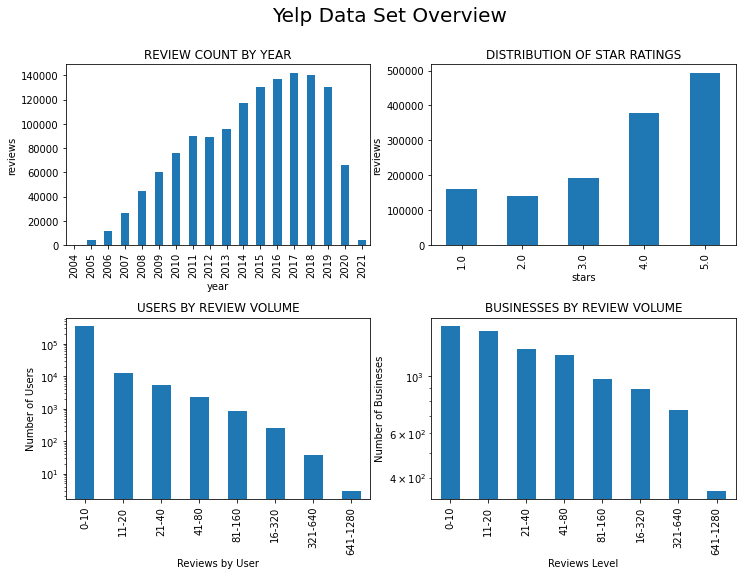

In [ ]:
#@title Plot Yelp Data Set Info {display-mode: "form"}
#@markdown The charts below show the data coverage in the full Yelp dataset. \


fig, axes = plt.subplots(2,2,  figsize=(12, 8), sharex=False, sharey=False)
fig.suptitle("Yelp Data Set Overview", fontsize=20)
plt.subplots_adjust(hspace=0.4)

# PLOT REVIEWS BY YEAR
ax = axes[0,0]    
fig.add_subplot(ax)
yelp_ds1['date'].groupby(yelp_ds1.date.dt.to_period("Y")).agg('count').plot(ax=ax,title='REVIEW COUNT BY YEAR', xlabel='year', ylabel='reviews', kind='bar');

# PLOT REVIEWS BY STAR RATING
ax = axes[0,1]    
fig.add_subplot(ax)
yelp_ds1['stars'].groupby(yelp_ds1.stars).agg('count').plot(ax=ax, title='DISTRIBUTION OF STAR RATINGS', ylabel='reviews', kind='bar');

# PLOT REVIEWS BY USER
ax = axes[1,0]    
fig.add_subplot(ax)
x = yelp_ds1['user_id'].groupby(yelp_ds1.user_id).agg('count').value_counts(bins=[0,10,20,40,80,160,320,640,1280]).round(0)
x.index = ['0-10', '11-20','21-40','41-80','81-160','16-320','321-640', '641-1280']
x.plot(ax=ax, kind='bar',
       xlabel='Reviews by User', 
       ylabel='Number of Users',
       title='USERS BY REVIEW VOLUME',
       logy=True);

# PLOT REVIEWS PER RESTAURNT
ax = axes[1,1]    
fig.add_subplot(ax)
x = yelp_ds1['BusinessName'].groupby(yelp_ds1.BusinessName).agg('count').value_counts(bins=[0,10,20,40,80,160,320,640,3080])
x.index = ['0-10', '11-20','21-40','41-80','81-160','16-320','321-640', '641-1280']
x.plot(ax=ax, kind='bar',
       xlabel='Reviews Level', 
       ylabel='Number of Busineses',
       title='BUSINESSES BY REVIEW VOLUME',
       logy=True);


  

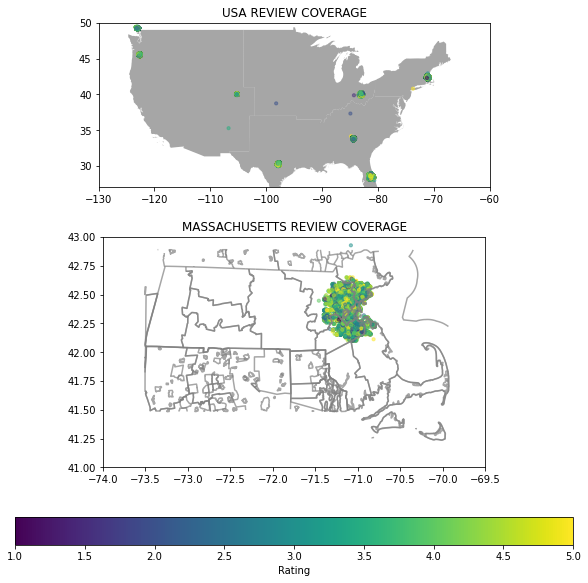

In [ ]:
#@title Restaurant Locations in Yelp Dataset {display-mode: "form"}
#@markdown The the full Yelp data set covers 8 metro areas.  This project uses only data for Restaurants in Massachusetts 

# create figure and axes, assign to subplot
fig, axes = plt.subplots(2, 1, figsize=(10,10),
                         gridspec_kw={'height_ratios': [1, 2]},
                         sharex=False, sharey=False)

# US GEOGRAPHIC REVIEW COVERAGE
us_map = HOMEDIR + "cb_2018_us_region_5m.shp"

usdat = business_df[['longitude', 'latitude', 'state', 'rating']]
# United States
lat_min = 27.0
lat_max = 50.0
lon_min = -130.0
lon_max = -60.0

us_street_map = gpd.read_file(us_map)
crs = CRS('EPSG:4326')
us_geometry = [Point(xy) for xy in zip(usdat['longitude'], usdat['latitude'])]
us_geo_df = gpd.GeoDataFrame(usdat, crs = crs, geometry = us_geometry)

ax = axes[0]
us_street_map.plot(ax=ax, alpha=0.7,color='grey')
ax.title.set_text('USA REVIEW COVERAGE')
ax.set_xlim([lon_min, lon_max])
ax.set_ylim([lat_min,lat_max])
us_geo_df.plot(column='rating',ax=ax,alpha=0.5, 
            legend=False, markersize=10,
            legend_kwds={'label': "Rating", 'orientation': "horizontal"})


# MASSACHUSETTS GEOGRAPHIC REVIEW COVERAGE
#mass_map = HOMEDIR + "tl_2017_25_place.shp"
mass_map = "/content/drive/MyDrive/Colab_Notebooks/ProjectDat/massachusetts_administrative.shp"

mdat = business_df[['longitude', 'latitude', 'state', 'rating']].copy()
# massacusetts
lat_min = 41.0
lat_max = 43.0
lon_min = -74.0
lon_max = -69.5

rev_in = len(mdat)
mdat =  mdat[(mdat['latitude'] >= lat_min) & 
(mdat['latitude'] < lat_max) &
(mdat['longitude'] >= lon_min) & 
(mdat['longitude'] <= lon_max)]

m_street_map = gpd.read_file(mass_map)
m_crs = CRS('EPSG:4326')
m_geometry = [Point(xy) for xy in zip(mdat['longitude'], mdat['latitude'])]
m_geo_df = gpd.GeoDataFrame(mdat, crs = m_crs, geometry = m_geometry)

ax = axes[1]

m_street_map.plot(ax=ax, alpha=0.7,color='grey')
ax.title.set_text('MASSACHUSETTS REVIEW COVERAGE')
ax.set_xlim([lon_min, lon_max])
ax.set_ylim([lat_min,lat_max])
m_geo_df.plot(column='rating',ax=ax,alpha=0.5, 
            legend=True, markersize=10,
            legend_kwds={'label': "Rating", 'orientation': "horizontal"})



plt.show()

#SENTIMENT ANALYSIS OF REVIEWS

In [ ]:
#@title Compute Sentiment for Reviews {display-mode: "form"}
#@markdown training code (ds_train) to be added

In [ ]:
#@title Predicting Sentiment for Reviews {display-mode: "form"}
#@markdown to be added \
#@markdown uses model created above to predict sentiment on ds_test \
#@markdown outputs ds_sentiment- a global dataframe with shape [num-reviews x 1] \
#@markdown entry for each review: -1 = negative sentiment, +1 = positive sentiment
def predict_sentiment(model, ds, threshold=.25):
  d = pd.DataFrame(np.where(ds[['stars']] > 3.5, 1, -1))
  d.columns = ['sentiment']
  return d

ds_sentiment = predict_sentiment(0, ds_test)
print('Sentiment Computed')

Sentiment Computed


#TOPIC ANALYSIS OF REVIEWS
LDA and MMF models were implemented and compared to extract topic information from the review text in the Yelp data set. Each model had slightly different pre-processing stacks and requirements.  Scikit 

Scikit NMF was implemented with reaonable results without much tweaking. LDA tool kits from Scikit and Gensim were also implemented, each having different pre-processing requirements and strengthsweaknesses. Gensim had better support for coherence/perplexity measurements and prior configuration.  The scikit LDA seemed faster and used similar preprocessing as the NMF kit.

## Training LDA and NMF Models


In [ ]:
#@title Train NMF and NMF Models Models {display-mode: "form"}
#@markdown NOTE: This cell takes about an hour to run.  
#@markdown The resulting datasets are loaded with the initial cell in this notebook.
#@markdown so you can skip this and run the rest of the cells.

# PREPROCESS DATA FOR SCIKIT NMF & LDA###
documents = ds_train.review

# Add additional stop words for removal during proprocessing.
# These stop words are added to the standard English stopwords from the scikit 
# package. Defining these removes non-predictive words that that appear across topics.
stop_list =  ['18', '20', '30', 'absolutely', 'asked', 'better', 'bit', 'came', 'com', 
           'come', 'did', 'didn', 'don', 'fi', 'food', 'going', 'got', 'just', 'know', 
           'la', 'like', 'lot', 'love', 'make', 'nice', 'ok', 'place', 'probably', 
           'really', 'restaurant', 'said', 'sat', 'say', 'sit', 'thing', 'think', 
           'today', 'told', 'try', 'usually', 've', 'want', 'way', 'went', 'wi', 
           'www', 'ya']
stop_list = list(set(_stoplist))
stop_list.sort()

my_stopwords = text.ENGLISH_STOP_WORDS.union(stop_list)

no_features =100000

# scikit NMF tf-idf preprocessing
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words=my_stopwords)
tfidf_fit = tfidf_vectorizer.fit(documents)
tfidf = tfidf_fit.transform(documents)
tfidf_test = tfidf_fit.transform(ds_test.review)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# scikity LDA uses raw term counts because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words=my_stopwords)
tf_fit = tf_vectorizer.fit(documents)
tf = tf_fit.transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names_out()

### TRAIN NMF AND LDA MODELS

no_topics = 20

# TRAIN SCIKIT NMF
with warnings.catch_warnings():
	# ignore all caught warnings
  warnings.filterwarnings("ignore")
  nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# TRAIN SCIKIT LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

# Save Models to Disk 
with open(SCIMODEL_LDA, 'wb') as f:
    pickle.dump(lda, f)

with open(SCIMODEL_NMF, 'wb') as f:
    pickle.dump(nmf, f)

with open(SCIMODEL_TFNMF, 'wb') as f:
    pickle.dump(tfidf_fit, f)

with open(SCIMODEL_TFNMF_VECT, 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

with open(SCIMODEL_TFNMF_TFIDF, 'wb') as f:
    pickle.dump(tfidf, f)



with open(SCIMODEL_TFLDA, 'wb') as f:
    pickle.dump(tf_fit, f)

with open(SCIMODEL_TFLDA_VECT, 'wb') as f:
    pickle.dump(tf_vectorizer, f)

with open(SCIMODEL_TFLDA_TF, 'wb') as f:
    pickle.dump(tf, f)


with open(SCIMODEL_NMF_FEATURES, 'wb') as f:
    pickle.dump(tfidf_feature_names, f)

with open(SCIMODEL_LDA_FEATURES, 'wb') as f:
    pickle.dump(tf_feature_names, f)


tz_NY = pytz.timezone('America/New_York') 
datetime_NY = datetime.now(tz_NY)
print('FINISHED TRAINING', datetime_NY)


FINISHED TRAINING 2021-12-05 12:42:35.035594-05:00


In [ ]:
#@title Word Mapping to Topics  {display-mode: "form"}
#@markdown Plot each topic with the top words that define it.  The list of words
#@markdown 

# Heavily modified code from:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause


def plot_top_words(model, feature_names, n_top_words, title):
    num_topics = topic_count(model)
    # Set up grid dimensions
    grid_cols = 4
    plot_width = 12 
    grid_rows = (num_topics + grid_cols - 1) // grid_cols 
    plot_height = grid_rows * plot_width // grid_cols
    
    fig, axes = plt.subplots(grid_rows,grid_cols,  figsize=(plot_width, plot_height), sharex=True)
    ax_stack = []
    for topic_idx, (ax, topic) in enumerate(zip(axes.flatten(), model.components_)):
      if topic_idx >= num_topics:
        # if no more topics, clear unused plots on grid
        ax.set_axis_off() 
      else:
        ax_stack.append(ax)
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx }", fontdict={"fontsize": 18})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=10)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=20)

    # add axis labels to last row
    for i in range(0, min(grid_cols, len(ax_stack))):  
      a = ax_stack.pop()
      a.xaxis.set_tick_params(which='both', labelbottom=True, rotation=0)
  

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


n_top_words = 15

def plot_topic_words(mod):
  output.clear()
  if mod == 'T':
    plot_top_words(
        nmf,
        tfidf_feature_names,
        n_top_words,
        "Topics in NMF Topics (generalized Kullback-Leibler divergence)",
    )

  if mod == 'L':
    plot_top_words(
      lda,
      tf_feature_names,
      n_top_words,
      "Topics in LDA Topics (Latent Dirichlet Allocation)",
    )

interactive(plot_topic_words, mod=RadioButtons(options=[('NMF','T'),('LDA', 'L')], description='Choose Model', disabled=False))

interactive(children=(RadioButtons(description='Choose Model', options=(('NMF', 'T'), ('LDA', 'L')), value='T'…

In [ ]:
#@title Scikit pyLDAvis LDA Model Visualization {display-mode: "form"}
#@markdown Investigate topics in Scikit LDA model.

from __future__ import print_function 
if 'pyLDAvis' not in sys.modules:
  !pip install pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16     0.151527  0.148115       1        1  14.475888
9      0.140231  0.220056       2        1  11.575338
19     0.194164  0.019172       3        1   9.824535
14     0.206241  0.071433       4        1   8.446661
18    -0.005652 -0.170302       5        1   6.969934
10     0.109331  0.008740       6        1   6.233451
15     0.165195 -0.132102       7        1   5.705596
11     0.059053  0.152583       8        1   4.496416
13     0.088662 -0.029842       9        1   4.487979
0      0.119796 -0.087543      10        1   4.155379
7     -0.031319 -0.121105      11        1   3.822615
3     -0.057807 -0.180317      12        1   3.573567
6      0.019071 -0.101416      13        1   2.959362
8      0.033911 -0.118335      14        1   2.908811
17    -0.068928  0.214834      15        1   2.533390
5     -0.155477 -0.146295      16        1   2.242069
4     -0.184629  0.141159      17        1   2.121090
12    -0.213946 -0.087407      18        1   1.328768
2     -0.282391  0.090865      19        1   1.170562
1     -0.287035  0.107707      20        1   0.968589, topic_info=           Term           Freq          Total Category  logprob  loglift
62731     order  233760.000000  233760.000000  Default  30.0000  30.0000
67448     pizza  171122.000000  171122.000000  Default  29.0000  29.0000
39158     great  487928.000000  487928.000000  Default  28.0000  28.0000
18486   chicken  227398.000000  227398.000000  Default  27.0000  27.0000
75910     salad  115295.000000  115295.000000  Default  26.0000  26.0000
...         ...            ...            ...      ...      ...      ...
87782     tends    2515.879584    2516.836422  Topic20  -5.1979   4.6367
69598   pricier    2449.588916    2450.545754  Topic20  -5.2246   4.6367
58862    museum    2198.393684    2199.350522  Topic20  -5.3328   4.6366
60679       non    6864.638077   15381.016146  Topic20  -4.1941   3.8303
6337   appetite    2530.555960    3774.254090  Topic20  -5.1921   4.2373

[1132 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
117        1  0.092165         10
117        2  0.538239         10
117        3  0.111073         10
117        4  0.001891         10
117        7  0.015019         10
...      ...       ...        ...
98582     13  0.027159      years
98650     13  0.999980       yelp
98732      9  0.999887  yesterday
99129     16  0.999972      yummy
99543      7  0.999617       ziti

[2325 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 10, 20, 15, 19, 11, 16, 12, 14, 1, 8, 4, 7, 9, 18, 6, 5, 13, 3, 2])

In [ ]:
#@title Gensim LDA Topics {display-mode: "form"}
#@markdown Investigate topics in Gensim LDA model.


## Table of Topics (columns) with highest probability word (list)
def view_model_topics(model, num_words=20):
    topic_cnt = len(lda_model.print_topics(num_words=20))

    # PRINT TABLE WITH TOPICS DISCOVERED FROM TRAINING SET 
    # with their associated words/probabilities
    tab_out = PrettyTable()
    print("Model (TRAINING SET) Topics Words From Training by Probability*Word") 
    for c in range(0, topic_cnt):
      tab_out.add_column(f'Topic{c}', lda_model.print_topics(num_words=20)[c][1].split('+'))
      tab_out.align[f'Topic{c}'] = 'l'
    print(tab_out)

print(view_model_topics(lda_model, num_words=20))



Model (TRAINING SET) Topics Words From Training by Probability*Word
+---------------------+------------------+------------------+---------------------+------------------------+------------------+---------------------+--------------------+------------------+---------------------+---------------------+----------------------+-------------------+---------------------+
| Topic0              | Topic1           | Topic2           | Topic3              | Topic4                 | Topic5           | Topic6              | Topic7             | Topic8           | Topic9              | Topic10             | Topic11              | Topic12           | Topic13             |
+---------------------+------------------+------------------+---------------------+------------------------+------------------+---------------------+--------------------+------------------+---------------------+---------------------+----------------------+-------------------+---------------------+
| 0.024*"great"       | 0.018*"thi"

In [ ]:
#@title Gensim pyLDAvis LDA Model Visualization {display-mode: "form"}
#@markdown Investigate topics in Gensim LDA model.

from __future__ import print_function 
if 'pyLDAvis' not in sys.modules:
  !pip install pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, bow_train, lda_dict)


/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.197547  0.087891       1        1  11.419850
0     -0.043270 -0.157405       2        1  10.632707
1     -0.168197  0.018473       3        1  10.151625
7     -0.206824  0.069343       4        1  10.093396
2      0.090376  0.089961       5        1   9.713417
5     -0.080960 -0.129000       6        1   9.149881
9     -0.058993 -0.180215       7        1   8.934335
11    -0.201758  0.093004       8        1   5.672558
10     0.170757  0.109679       9        1   5.602353
13     0.150061  0.190217      10        1   4.959192
3      0.070281 -0.078526      11        1   4.599323
6      0.111170  0.051513      12        1   3.708612
12     0.147168 -0.084893      13        1   3.009575
4      0.217735 -0.080041      14        1   2.353176, topic_info=        Term           Freq          Total Category  logprob  loglift
150    pizza   30168.000000   30168.000000  Default  30.0000  30.0000
120     time   63198.000000   63198.000000  Default  29.0000  29.0000
58      food  117324.000000  117324.000000  Default  28.0000  28.0000
225    great   72671.000000   72671.000000  Default  27.0000  27.0000
125     wait   33069.000000   33069.000000  Default  26.0000  26.0000
...      ...            ...            ...      ...      ...      ...
1346  french     980.243318    3742.412383  Topic14  -5.3966   2.4097
562      hot    1095.883180   13691.629299  Topic14  -5.2851   1.2242
28     water     895.326477    8034.308572  Topic14  -5.4873   1.5551
62      good    1009.833381  100376.602246  Topic14  -5.3669  -0.8497
691      new     910.457628   12713.550593  Topic14  -5.4705   1.1129

[999 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2514      5  0.035283  abov_averag
2514      6  0.965106  abov_averag
2822      8  1.000684  abov_beyond
1762      3  0.999938       access
262       3  0.875183       across
...     ...       ...          ...
1411     12  0.008267         yelp
1411     13  0.024800         yelp
1411     14  0.001945         yelp
2466      8  0.999296  yelp_review
2082     12  0.999579         york

[2796 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 1, 2, 8, 3, 6, 10, 12, 11, 14, 4, 7, 13, 5])

In [ ]:
#@title Creat Topic Names{display-mode: "form"}   
#@markdown Here we attempt to assign a human interpretable name to each topic.  \
#@markdown By default, topics recieve a numbered tag as an id.  In this section,  
#@markdown a human readable name is assembled from the highest probability words from the topic.  

def name_topics():
  top_dict = {}
  no_top_words = 15
  feature_names = tfidf_feature_names
  for i, topic in enumerate(nmf.components_):
    top_dict['T' + str(i)] = ''.join([feature_names[i]  for i in topic.argsort()[:-no_top_words - 1:-1]])
  feature_names = tf_feature_names
  for i, topic in enumerate(lda.components_):
    top_dict['L' + str(i)] = ''.join([feature_names[i]  for i in topic.argsort()[:-no_top_words - 1:-1]])
  return(top_dict)   
# pprint(name_topics())

TOPIC_NAMES = {'L0': '_??Price/Value',
 'L1': '_Chain?Mediterraiian',
 'L10': 'Dining Experience',
 'L11': '_FunP Place',
 'L12': '_Thai',
 'L13': '_Coffee/Tea',
 'L14': 'Drinks',
 'L15': '_Breakfast/Brunch',
 'L16': '_Bad Service',
 'L17': '_Delivery Service',
 'L18': 'Flavors',
 'L19': '_Good Lunch',
 'L2': '_Vietnamese',
 'L3': '_Chinese',
 'L4': '_??Hotel',
 'L5': '_Burgers',
 'L6': '_Pizza',
 'L7': '_Lunch',
 'L8': '_Seafood',
 'L9': '_Long Wait',
 'T0': 'Great',
 'T1': 'Pizza',
 'T10': 'Burgers',
 'T11': 'Friendly Staff',
 'T12': 'Thai',
 'T13': 'Service',
 'T14': 'Fun & Drinks',
 'T15': 'Lunch',
 'T16': 'Long Wait (worth it?)',
 'T17': 'Sandwiches',
 'T18': 'Amazing/Recommend',
 'T19': 'Coffee',
 'T2': 'Great Atmosphere',
 'T3': '??ChickenFriedRice',
 'T4': 'Seafood',
 'T5': 'Breakfast/Brunch',
 'T6': 'Sushi',
 'T7': 'Bad Service',
 'T8': 'Beer/Pub',
 'T9': 'Best'}


{'L0': 'pricepriceswingstacoschipsqualitysmallgreatmexicandecentservicelittlechickenportionssteak',
 'L1': 'bunchainalwafflemanonwrapsclassownedtendersmediterraneanstumbledelshawarmaplantains',
 'L10': 'menuwinedessertmealdinnerexperiencedeliciousdishesenjoyedspecialcoursediningchefexcellentwonderful',
 'L11': 'beerroombarramensquaregametableswatchgempeoplediningspaceharvardstandardbeers',
 'L12': 'thaitoastindianbuffetchickenpadfrenchpancakesdinercurrykidsweekendsnaancomfortmasala',
 'L13': 'coffeeteachocolatecreamcafeseatingsweetcupdeliciouslittlehotmilkplentyshopsandwiches',
 'L14': 'greatbardrinksserviceatmospherenightfriendlystaffdrinkfriendsamazingtimebeerfundefinitely',
 'L15': 'greatdeliciousbreakfastservicepastaamazingbrunchitalianrecommendfriendlydefinitelybestfresheggsend',
 'L16': 'servicetimebadpeoplereviewstarseattimesstarexperiencestafforderllcustomermaybe',
 'L17': 'orderdeliveryorderedtimecalledpickicephone12orderinglateonlinereasonablyordersminutes',
 'L18': 'saucefla

#TOPIC DISCOVERY FROM REVIEWS

Reviews 273110
Scikit LDA Reviews with Topic: 99.65874556039691%
Reviews 273110
Scikit NMF Reviews with Topic: 57.293398264435574%
Reviews 273110
Gensim LDA Reviews with Topic: 14.643916370693127%

Topic Data Prediction Complete


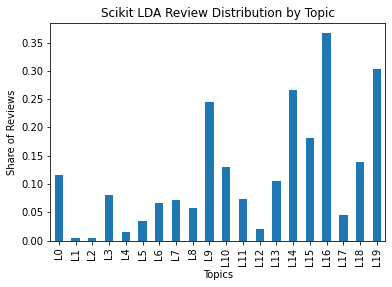

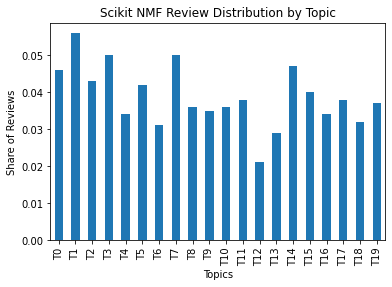

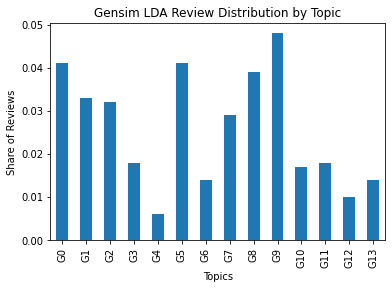

In [ ]:
#@title Predict Topics from Reviews {display-mode: "form"}
#@markdown Use NMF and IDF models to predict topics in the test data set.

##### NEW RUN AGAINST TEST DATA SET #####
# Gensim LDA model
def genpredict_topics(model, ds, bow, threshold=.25, tag='G', caption=""):
  # model =     gensim lda model (lda_model)
  # reviews =   data set with reviews text from ds_test
  # bow = bag of works for review text
  # threshold = returns 0 for items < threshold
  # tag = prefix used in column identifier, e.g. G0, G1, ...
  # caption = the name of the model for the plot title
  # RETURNS = predictions dataframe shape [reviews x Topics]

  topics_out = model.get_document_topics(bow, minimum_probability=threshold)
  num_topics  = len(model.print_topics(num_words=2))
  num_reviews = ds.shape[0]
  topics_new = np.zeros((num_reviews, num_topics),dtype=int)
  for x, tops in enumerate(topics_out):
    for t in tops:
      if t[1] > threshold and t[0] < num_topics:
        topics_new[x,t[0]] = 1
  
  topics_new = np.where(topics_new < threshold, 0, topics_new).round(3)   # zero out prob < threshold
  col_names = [tag + str(x) for x in range(0, topics_new.shape[1])]
  df_mat = pd.DataFrame(topics_new, columns = col_names)

  # show plot of topic distibution
  print('Reviews', num_reviews)
  print('{} Reviews with Topic: {}%'.format(caption, 100*np.sum(np.sum(topics_new>0, axis=1)>0,axis=0) / num_reviews))
  x = np.sum(topics_new>0, axis=0) / num_reviews
  top_dist = pd.DataFrame(x.round(3).reshape(1,-1), columns=col_names)
  title = caption + ' Review Distribution by Topic'
  top_dist.T.plot(kind='bar', title=title,
                  xlabel='Topics', ylabel='Share of Reviews',
                  legend=False)
  return df_mat   # pandas dataframe shape (reviews x topics) 

# scikit LDA and NMF model predictions
def scipredict_topics(tfidf_fit, model, reviews, threshold=.02, tag='T', caption=""):
  # tfidf_fit = tfidf_fit (for NMF) or tf_fit (for LDA)
  # model =     nmf or lda model
  # reviews =   reviews text from ds_test
  # threshold = returns 0 for items < threshold
  # tag = prefix used in column identifier, e.g. T0, T1, ...
  # caption = the name of the model for the plot title
  # RETURNS = predictions dataframe shape [reviews x Topics]

  # NMF or LDA model prediction (ignore warning messages)
  with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    tfidf_test = tfidf_fit.transform(reviews)          # vectorize
    topics_new = model.transform(tfidf_test)      # model prediction
  num_reviews = len(reviews)
  topics_new = np.where(topics_new < threshold, 0, topics_new).round(3)   # zero out prob < threshold
  col_names = [tag + str(x) for x in range(0, topics_new.shape[1])]
  df_mat = pd.DataFrame(topics_new, columns = col_names)
  
  # show plot of topic distibution
  print('Reviews', num_reviews)
  print('{} Reviews with Topic: {}%'.format(caption, 100*np.sum(np.sum(topics_new>0, axis=1)>0,axis=0) / num_reviews))
  x = np.sum(topics_new>0, axis=0) / num_reviews
  top_dist = pd.DataFrame(x.round(3).reshape(1,-1), columns=col_names)
  title = caption + ' Review Distribution by Topic'
  top_dist.T.plot(kind='bar', title=title,
                  xlabel='Topics', ylabel='Share of Reviews',
                  legend=False)
  return df_mat   # pandas dataframe shape (reviews x topics) 

ds_topics = pd.DataFrame()
## Scikit LDA
tf_feature_names = tf_fit.get_feature_names_out()
ds_topics = pd.concat([ds_topics, scipredict_topics(tf_fit, lda, ds_test.review, threshold=.15, tag='L', caption="Scikit LDA")], axis=1)
pd.concat([ds_test, ds_sentiment, ds_topics], axis=1)

## Scikit NMF
tfidf_feature_names = tfidf_fit.get_feature_names_out()
ds_topics = pd.concat([ds_topics, scipredict_topics(tfidf_fit, nmf, ds_test.review, threshold=.005, tag='T', caption="Scikit NMF")], axis=1)

## Gensim LDA
ds_topics = pd.concat([ds_topics, genpredict_topics(lda_model, ds_test, bow_test, threshold=.15, tag='G', caption="Gensim LDA")], axis=1)
print("\nTopic Data Prediction Complete")



In [ ]:
#@title Explore Review Text by Topic {display-mode: "form"}   
#@markdown Review topic predictions for the test dataset by show random \
#@markdown review text with topic relevant words marked.  
#@markdown The object is verify the top accurately classifies the topic.   
ds_final = pd.concat([ds_test, ds_sentiment, ds_topics], axis=1)

def topicwords(model, feature_names, no_top_words):
    l = []
    for topic_idx, topic in enumerate(model.components_):
         l.append(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    l = [c.split() for c in l]
    return(l)   

def topic_text(topic_no, tag):  
  no_top_words = 40
  if tag == 'L':
    topicToWords = topicwords(lda, tf_feature_names, no_top_words)
  else:  # if tag == 'T':
    topicToWords = topicwords(nmf, tfidf_feature_names, no_top_words)

  # Set pd so it won't truncate, set wrap parms
  pd.set_option('max_colwidth', 4000)
  pd.options.display.max_columns=400
  wrapper = textwrap.TextWrapper(width=100)

  num_topics = len([idx for idx in ds_final.columns if idx.startswith(tag)])

  output.clear()
  w1 = topicToWords[topic_no][0:10]
  w2 = topicToWords[topic_no][11:40]
  print('\nTOPIC WORDS:', w1)
  print('            ', w2)
  print('             ', Back.RED + Fore.WHITE + "Top-!0 Prob", Style.RESET_ALL, "  ", Back.GREEN + Fore.WHITE + "Lower Prob" + Style.RESET_ALL)
  ds1 = ds_final[ds_final[tag + str(topic_no)] > 0 ]
  if len(ds1) == 0:
    print('No Reviews for this topic')
    return

  samp = randint(0, len(ds1)-1)
  cc = ds1.iloc[samp]['review'].lower()
  print('\n')
  try:
    print(Back.BLUE + Fore.WHITE + 'TOPIC: ', TOPIC_NAMES[tag + str(topic_no)], Style.RESET_ALL)
  except:
    print(Back.BLUE + Fore.WHITE + 'TOPIC ', str(topic_no), Style.RESET_ALL,)
  print(Fore.BLUE, ds1.iloc[samp]['BusinessName'], Style.RESET_ALL,
        ds1.iloc[samp]['rating'], 'stars',
        'Topic Prob:', ds1.iloc[samp][tag + str(topic_no)])

  print('Review:', ds1.iloc[samp]['stars'],
        'Sentiment:', ds1.iloc[samp]['sentiment'])
  ccc = ""
  for word in str(cc).split(' '):
    if word in w1:
        ccc = ccc + Back.RED + Fore.WHITE + word + " "
    elif word in w2:
        ccc = ccc + Back.GREEN + Fore.WHITE + word + " "
    else:
        ccc = ccc + Style.RESET_ALL + word + " "
  #print('\n')
  print(wrapper.fill(text=ccc))

num_topics = len([idx for idx in ds_final.columns if idx.startswith('T')])

from google.colab import output

topic_no=IntSlider(min=0, max=num_topics-1, step=1, description='Select Topic:')
tag=RadioButtons(options=[('NMF','T'),('LDA', 'L')], description='Model', disabled=False)
#ui = widgets.HBox([topic_no, tag])
#out = interactive_output(topic_text, {'topic_no':topic_no, 'tag':tag})
#display(ui, out)
layout = Layout(display='hbox',
                    flex_flow='row',
                    align_items='stretch',
                    border='solid',
                    width='50%')
wid=interactive(topic_text, {'manual' : True, 'manual_name' :'view text'}, 
                  topic_no=topic_no, tag=tag, layout=layout)

controls = widgets.HBox(wid.children[:-1], layout = Layout(flex_flow='row wrap'))
xout = wid.children[-1]
print("View Review Text by Topic")
display(widgets.VBox([controls, xout], layout=Layout(width='60%')))


View Review Text by Topic


In [ ]:
type(tf_fit)

sklearn.feature_extraction.text.CountVectorizer

# THE ANSWER: USING SENTIMENT AND TOPICS TO ANALYZE REVIEWS
For 40,000 Reviews 
Concatenate ds_test, ds_sentiment, ds_topics
  ds_test: review date, stars, restaurent, location, rating, categrories
  ds_sentiment - 0/1 for user sentiment
  ds_topics - one-hot array with 1 for topics covered in the review
Analyze for insights
e.g.
  - top restaurants for each topic
  - changes over time
  ....


In [ ]:
#@title Top 10 Cambridge Restaurants Sentiment Rank by Topic {display-mode: "form"}

# Calculate Top Restaurant Per Topic
# Concatenate data sets
ds_final = pd.concat([ds_test, ds_sentiment, ds_topics], axis=1)

def get_top10(ds, tcol, city):
    # ds=ds_final, tcol=topic column name (e.g. 'T1')
    top10 = ds[(ds['review_count'] > 10) & (ds[tcol] > 0) & (ds['city'] == city)]
    top10 = top10.groupby('BusinessName').agg({'city':'first', 'review_count':'first', 'rating':'first','sentiment':'mean', tcol:'count'})
    top10 = top10[top10[tcol] > 3].sort_values('sentiment', ascending=False)[0:5]
    return top10


def Show_SentByTopic(ds, city, tag, plot=True):
  # Sentiment by Topic
  # Choose reviews in topic for restaurants with > 10 reviews
  num_topics = len([idx for idx in ds.columns if idx.startswith(tag)])

  if plot:
      # Set up grid dimensions
      grid_cols = 4
      plot_width = 12 
      grid_rows = (num_topics + grid_cols - 1) // grid_cols 
      plot_height = (grid_rows * plot_width // grid_cols) -4
      
      fig, axes = plt.subplots(grid_rows,grid_cols,  figsize=(plot_width, plot_height), sharex=True)
      ax_stack = []

      for x, ax in enumerate(axes.flatten()):
          t = tag + str(x)
          if x >= num_topics:
            # if no more topics, clear unused plots on grid
            ax.set_axis_off() 
          else:
            ax_stack.append(ax)
            top10 = get_top10(ds_final, t, city)

            #top10 = ds[(ds['review_count'] > 10) & (ds[t] > 0) & (ds['city'] == city)]
            #top10 = top10.groupby('BusinessName').agg({'city':'first', 'review_count':'first', 'rating':'first','sentiment':'mean', t:'count'})
            #top10 = top10[top10[t] > 3].sort_values('sentiment', ascending=False)[0:5]
            
            rating = top10['sentiment']
            rating[rating < 0] = 0   #remove negative values
            restaurant = [a1[0:15] for a1 in top10.index.values] # shorten restaurant name
            ax.barh(restaurant, rating, height=0.4)
            try:
              top = TOPIC_NAMES[tag + str(x)]
            except:
              top = f"Topic {x }"
            ax.set_title(top, fontdict={"fontsize": 14})
            ax.invert_yaxis()
            ax.tick_params(axis="both", which="major", labelsize=10)
            for i in "top right left".split():
                ax.spines[i].set_visible(False)
            title = 'Top-10 Restaurants by Topic '+ city
            fig.suptitle(title, fontsize=20)
      # add axis labels to last row
      for i in range(0, min(grid_cols, len(ax_stack))):  
          a = ax_stack.pop()
          a.xaxis.set_tick_params(which='both', labelbottom=True, rotation=0)
      plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
      plt.show()
  else:  # not plot - detailed texy output
      for tcol in [idx for idx in ds.columns if idx.startswith(tag)]:
        try:
          print(Back.BLUE + Fore.WHITE + TOPIC_NAMES[tcol], Style.RESET_ALL)
        except:
          print(Back.BLUE + Fore.WHITE + 'TOPIC ', tcol, Style.RESET_ALL)
        print(get_top10(ds_final, tcol, city))
        print(' ')



ds=fixed(ds_final)
city=widgets.Dropdown(options=['Boston', 'Cambridge'], value='Cambridge', description='City', disabled=False)
tag=RadioButtons(options=[('NMF','T'),('LDA', 'L')], description='Model', disabled=False)
plot=widgets.Checkbox(value=True, description='Plot')
ui = widgets.HBox([city, tag, plot])
out = interactive_output(Show_SentByTopic, {'ds':ds, 'tag':tag, 'city':city, 'plot':plot})
display(ui, out)

Output()

In [ ]:
#@title Positive Sentiment Rate by Topic {display-mode: "form"}

def plot_topic_time(ds, tag):
  num_topics = len([idx for idx in ds.columns if idx.startswith(tag)])

  dd = ds.melt(id_vars=['date', 'sentiment'], value_vars=[tag + str(x) for x in range(0, num_topics)])
  dd['date'] = pd.to_datetime(dd['date'])
  dd['sentiment'] = dd['sentiment'].where(dd.sentiment > 0, 0)
  # Set up grid dimensions
  grid_cols = 4
  plot_width = 12 
  grid_rows = (num_topics + grid_cols - 1) // grid_cols 
  plot_height = grid_rows * plot_width // grid_cols

  fig, axes = plt.subplots(grid_rows,grid_cols,  figsize=(plot_width, plot_height), sharex=True, sharey=True)
  ax_stack = []
  fig.suptitle("Positive Sentintiment Rate by Topic", fontsize=20)
  for i, ax in enumerate(axes.flatten()):
    #print(tag + str(i), end='')
    if i >= num_topics:
      # if no more topics, clear unused plots on grid
      ax.set_axis_off() 
    else:
      # add plot for a topic
      ax_stack.append(ax)
      fig.add_subplot(ax)
      p = dd[dd['variable'] == tag + str(i)].groupby(dd.date.dt.to_period("M")).agg({'sentiment':'mean'})
      topic = 'TOPIC {}{}'.format(tag, str(i))
      p.plot(ax=ax, title=topic, legend=False, rot=90,
            xlabel='Months', ylabel='Positive Rate')
  # add x-axis ticks to bottom plots
  for i in range(0, min(grid_cols, len(ax_stack))):  
    a = ax_stack.pop()
    a.xaxis.set_tick_params(which='both', labelbottom=True, rotation=90)
    

ds_final = pd.concat([ds_test, ds_sentiment, ds_topics], axis=1)
#plot_topic_time(ds_final, tag=tag)

interactive(plot_topic_time, ds=fixed(ds_final), tag=RadioButtons(options=[('NMF','T'),('LDA', 'L')], description='Choose Model', disabled=False))

interactive(children=(RadioButtons(description='Choose Model', options=(('NMF', 'T'), ('LDA', 'L')), value='T'…

In [ ]:
num_topics =12
tag='T'
ds_final = pd.concat([ds_test, ds_sentiment, ds_topics], axis=1)

dd = ds_final.melt(id_vars=['date', 'sentiment'], value_vars=[tag + str(x) for x in range(0, num_topics)])
dd['date'] = pd.to_datetime(dd['date'])
dd['sentiment'] = dd['sentiment'].where(dd.sentiment > 0, 0)

nn = dd[dd['variable'] == 'T8'].groupby(dd.date.dt.to_period("Y")).agg({'sentiment':'sum'})
len(nn)
print(nn)

      sentiment
date           
2004          1
2005         95
2006        320
2007        529
2008        755
2009       1081
2010       1366
2011       1765
2012       1669
2013       1847
2014       2309
2015       2826
2016       2774
2017       2891
2018       2487
2019       1680
2020        977
2021         54


In [ ]:
#@title Put Another Analysis Here {display-mode: "form"}
## ADD ANALYSIS CODE HERE